In [3]:
# Load required modules
%matplotlib inline
import math, os, cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import Image
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from yolov5.train import run as run_train
from yolov5.detect import run as run_detect
from  matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [7]:
# distributed GPUs
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2


In [3]:
# global variables
TEETH_DATASET, TEETH_PBL, TEETH_CEJ, TEETH_NUMBER = './dataset/original-data', './dataset/pbl-mask', './dataset/cej-mask', './dataset/teeth-color'
PBL_EPOCH, PBL_BATCH = 30 , 16
CEJ_EPOCH, CEJ_BATCH = 30 , 16
ORIGINAL_IMG_SIZE = (2752, 1372)

In [4]:
# global function declaration
# convert image to grayscale
def to_one_channel(image):
    return image[:,:,0] if len(image.shape)>2 else image

# resize the image
def resize_image(image, new_shape):
    image = image.resize((new_shape),Image.ANTIALIAS)
    return image

# restore original size
def restore_original_size(image):
    return cv2.resize(image, dsize=ORIGINAL_IMG_SIZE)

# split dataset into train and test
def split_train_test(tooth, masks, train_percentage):
    divide_index = math.ceil(len(tooth)*train_percentage/100)
    X_train=tooth[:divide_index,:,:,:]
    X_test=tooth[divide_index:,:,:,:]
    y_train=masks[:divide_index,:,:,:]
    y_test=masks[divide_index:,:,:,:]
    return (X_train, y_train),(X_test, y_test)

# loading dataset function
def load_dataset(dataset_folder, rgb = False, normalize = True):
    images = []
    pbl_file_list = os.listdir('./dataset/pbl-mask')
    for teeth in natsorted(os.listdir(dataset_folder)):
        if f'{teeth.split(".")[0]}_PBL_lable.png' in pbl_file_list or f'{teeth.split("_")[0]}_PBL_lable.png' in pbl_file_list:
            image = Image.open(os.path.join(dataset_folder, teeth))
            image = resize_image(image, (2752, 1372))
            width, height = image.size
            # image = image.crop((300, 300, width-300, height))
            image = resize_image(image, (512, 512))
            image = np.asarray(image) if rgb else to_one_channel(np.asarray(image))
            images.append(image)
    if not rgb:
        images = np.asarray(images) / 255.0 if normalize else np.asarray(images)
        images = np.reshape(images, (len(images),images.shape[1], images.shape[2], 1))
    return images

# rotate the image with specific angle
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

# data augumentation with rotation
def apply_rotation(dataset_dir):
    for teeth in natsorted(os.listdir(dataset_dir)):
        filename, extension = teeth.split('.')
        if teeth.endswith(".png") and 'flip' not in teeth:
            image = Image.open(os.path.join(dataset_dir, teeth))
            image = np.asarray(image)
            image_rotate_30 = rotate_image(image, 30)
            image_rotate_60 = rotate_image(image, 60)
            image_rotate_90 = rotate_image(image, 90)
            image_rotate_120 = rotate_image(image, 120)
            image_rotate_150 = rotate_image(image, 150)
            image_rotate_210 = rotate_image(image, 210)
            image_rotate_240 = rotate_image(image, 240)
            image_rotate_270 = rotate_image(image, 270)
            Image.fromarray(image_rotate_30).save(os.path.join(dataset_dir,f'{filename}_rotate_30.{extension}'))
            Image.fromarray(image_rotate_60).save(os.path.join(dataset_dir,f'{filename}_rotate_60.{extension}'))
            Image.fromarray(image_rotate_90).save(os.path.join(dataset_dir,f'{filename}_rotate_90.{extension}'))
            Image.fromarray(image_rotate_120).save(os.path.join(dataset_dir,f'{filename}_rotate_120.{extension}'))
            Image.fromarray(image_rotate_150).save(os.path.join(dataset_dir,f'{filename}_rotate_150.{extension}'))
            Image.fromarray(image_rotate_210).save(os.path.join(dataset_dir,f'{filename}_rotate_210.{extension}'))
            Image.fromarray(image_rotate_240).save(os.path.join(dataset_dir,f'{filename}_rotate_240.{extension}'))
            Image.fromarray(image_rotate_270).save(os.path.join(dataset_dir,f'{filename}_rotate_270.{extension}'))

# plot unet loss value
def unet_lost_history(history, save_filename):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
    plt.savefig(f'./result/unet/{save_filename}.png', facecolor='white', dpi=1000)
    plt.show()

In [5]:
# u-net model
class unet_model:
    def __init__(self, input_shape=(512,512,1)):
        self.input_shape = input_shape
    def model(self):
        # define input layer for UNET
        inputs=Input(shape= self.input_shape)
        
        conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        d1=Dropout(0.1)(conv1)
        conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
        b=BatchNormalization()(conv2)
        
        pool1 = MaxPooling2D(pool_size=(2, 2))(b)
        conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        d2=Dropout(0.2)(conv3)
        conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
        b1=BatchNormalization()(conv4)
        
        pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
        conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        d3=Dropout(0.3)(conv5)
        conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
        b2=BatchNormalization()(conv6)
        
        pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
        conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        d4=Dropout(0.4)(conv7)
        conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
        b3=BatchNormalization()(conv8)
        
        pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
        conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        d5=Dropout(0.5)(conv9)
        conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
        b4=BatchNormalization()(conv10)
        
        conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
        x= concatenate([conv11,conv8])
        conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
        d6=Dropout(0.4)(conv12)
        conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
        b5=BatchNormalization()(conv13)
        
        conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
        x1=concatenate([conv14,conv6])
        conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
        d7=Dropout(0.3)(conv15)
        conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
        b6=BatchNormalization()(conv16)
        
        conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
        x2=concatenate([conv17,conv4])
        conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
        d8=Dropout(0.2)(conv18)
        conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
        b7=BatchNormalization()(conv19)
        
        conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
        x3=concatenate([conv20,conv2])
        conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
        d9=Dropout(0.1)(conv21)
        conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)
        
        outputs = Conv2D(1,(1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv22)
        
        return Model( inputs = inputs, outputs = outputs)

In [6]:
print('==> Please wait. Loading dataset.')
# load dataset
original_dataset = load_dataset(TEETH_DATASET)
print('==> Loading PBL dataset.')
pbl_dataset = load_dataset(TEETH_PBL)
print('==> Loading CEJ dataset.')
cej_dataset = load_dataset(TEETH_CEJ)
# split dataset 80% train
print('==> Start splitting dataset.')
(pbl_X_train, pbl_y_train), (pbl_X_test, pbl_y_test) = split_train_test(original_dataset, pbl_dataset, 80)
(cej_X_train, cej_y_train), (cej_X_test, cej_y_test) = split_train_test(original_dataset, cej_dataset, 80)
print('==> Finish loading dataset.')

==> Please wait. Loading dataset.
==> Loading PBL dataset.
==> Loading CEJ dataset.
==> Start splitting dataset.
==> Finish loading dataset.


In [7]:
# Open a strategy scope.
with strategy.scope():
    # Start fitting PBL model
    print('==> Start training UNET for PBL boundary.')
    pbl_model = unet_model(input_shape = (512, 512, 1)).model()
    pbl_model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
pbl_history = pbl_model.fit(pbl_X_train,pbl_y_train, validation_split = 0.2, batch_size=PBL_BATCH, epochs=PBL_EPOCH, verbose=1)
pbl_model.save('./result/unet/unet_model_pbl.h5')
# pbl_model.summary()
unet_lost_history(pbl_history, 'unet_pbl')
print('Finish UNET training forPBl boundary.')

==> Start training UNET for PBL boundary.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/30
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


42/42 [==============================] - 38s 551ms/step - loss: 0.2466 - accuracy: 0.8727 - val_loss: 1.0400 - val_accuracy: 0.8882
Epoch 2/30
42/42 [==============================] - 15s 359ms/step - loss: 0.0861 - accuracy: 0.9603 - val_loss: 0.9880 - val_accuracy: 0.8882
Epoch 3/30
42/42 [==============================] - 15s 363ms/step - loss: 0.0600 - accuracy: 0.9705 - val_loss: 1.1278 - val_accuracy: 0.8882
Epoch 4/30
42/42 [==============================] - 16s 389ms/step - loss: 0.0484 - accuracy: 0.9741 - val_loss: 1.0795 - val_accuracy: 0.8882
Epoch 5/30
42/42 [==============================] - 15s 363ms/step - loss: 0.0402 - accuracy: 0.9769 - val_loss: 0.6807 - val_accuracy: 0.8664
Epoch 6/30
42/42 [==============================] - 15s 359ms/step - loss: 0.0334 - accuracy: 0.9792 - val_loss: 1.0956 - val_accuracy: 0.8899
Epoch 7/30
42/42 [==============================] - 15s 365ms/step - loss: 0.0325 - accuracy: 0.9797 - val_loss: 0.6239 - val_accuracy: 0.8727
Epoch 8/30

In [8]:
# predict PBL boundary
# pbl_model = tf.keras.models.load_model('./result/unet/unet_model_pbl.h5')
pbl_predictions = pbl_model.predict(pbl_X_test)

Instructions for updating:
use `experimental_local_results` instead.


From /home/ubuntu/.local/lib/python3.9/site-packages/keras/engine/training.py:2975: StrategyBase.unwrap (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
use `experimental_local_results` instead.


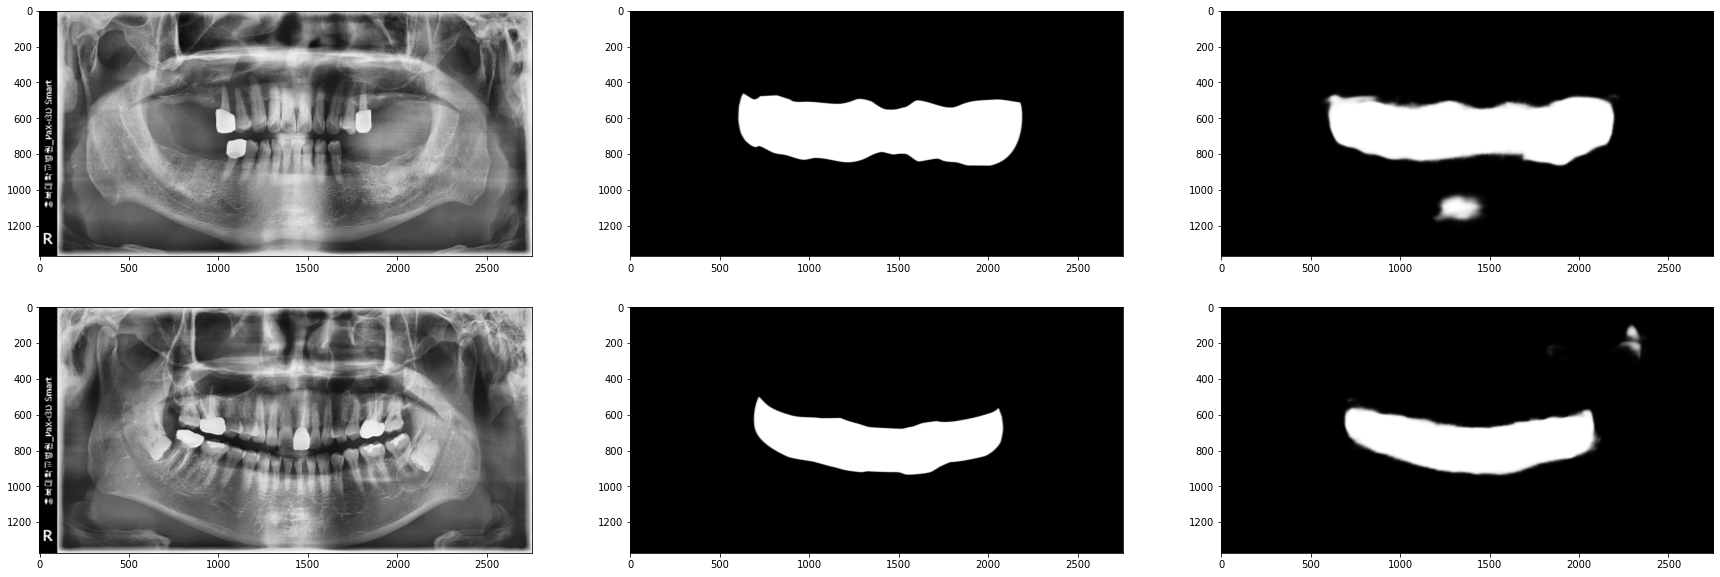

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))
ax[0][0].imshow(restore_original_size(pbl_X_test[4]), cmap = 'gray')
ax[0][1].imshow(restore_original_size(pbl_y_test[4]), cmap = 'gray')
ax[0][2].imshow(restore_original_size(pbl_predictions[4]), cmap = 'gray')
ax[1][0].imshow(restore_original_size(pbl_X_test[28]), cmap = 'gray')
ax[1][1].imshow(restore_original_size(pbl_y_test[28]), cmap = 'gray')
ax[1][2].imshow(restore_original_size(pbl_predictions[28]), cmap = 'gray')

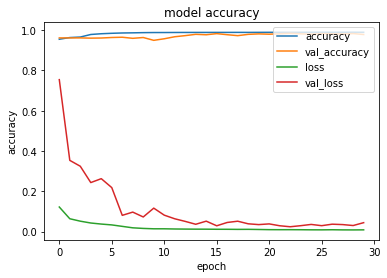

Finish UNET training for CEJ boundary.


In [10]:
# Open a strategy scope.
with strategy.scope():
    # Start fitting CEJ model
    print('==> Start training UNET for CEJ boundary.')
    cej_model = unet_model(input_shape = (512, 512, 1)).model()
    cej_model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cej_history = cej_model.fit(cej_X_train,cej_y_train, validation_split = 0.2, batch_size=CEJ_BATCH, epochs=CEJ_EPOCH, verbose=1)
cej_model.save('./result/unet/unet_model_cej.h5')
# pbl_model.summary()
unet_lost_history(cej_history, 'unet_cej')
print('Finish UNET training for CEJ boundary.')

In [11]:
# predict CEJ boundary
# cej_model = tf.keras.models.load_model('./result/unet/unet_model_cej.h5')
cej_predictions = cej_model.predict(cej_X_test)

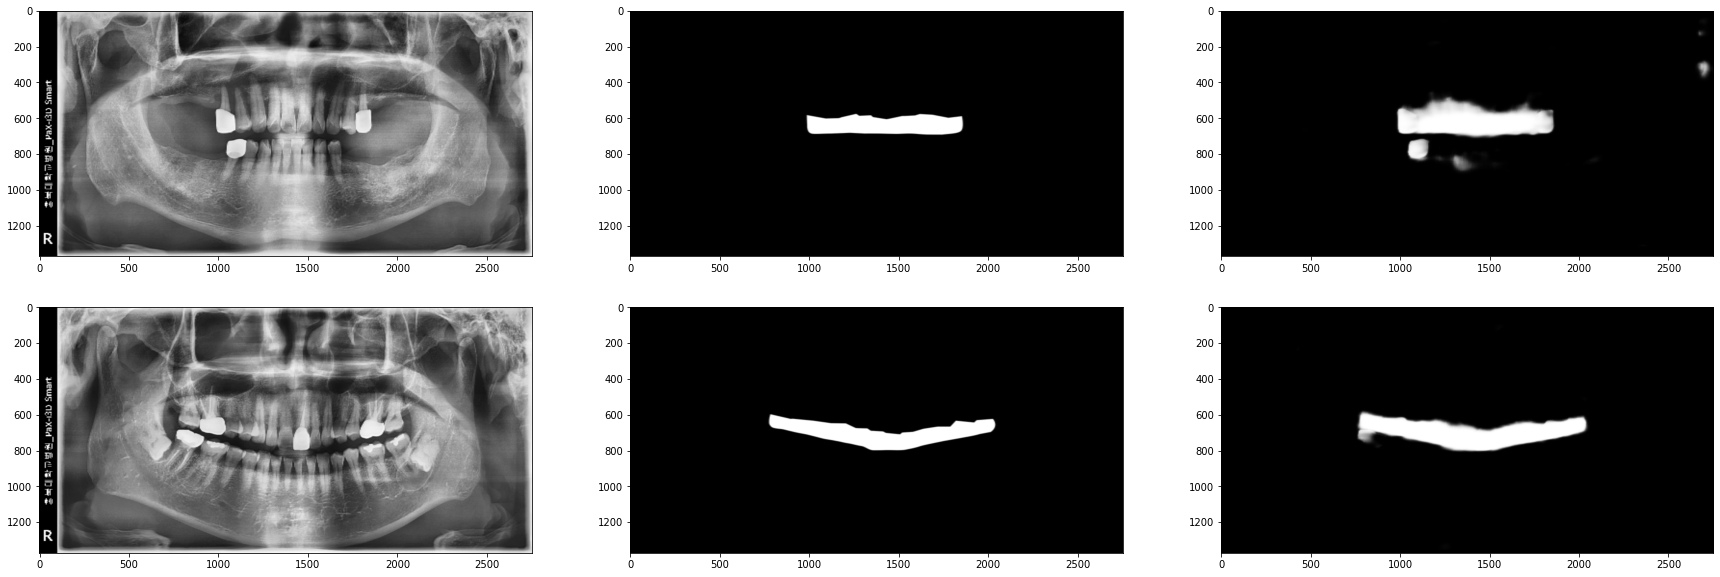

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))
ax[0][0].imshow(restore_original_size(cej_X_test[4]), cmap = 'gray')
ax[0][1].imshow(restore_original_size(cej_y_test[4]), cmap = 'gray')
ax[0][2].imshow(restore_original_size(cej_predictions[4]), cmap = 'gray')
ax[1][0].imshow(restore_original_size(cej_X_test[28]), cmap = 'gray')
ax[1][1].imshow(restore_original_size(cej_y_test[28]), cmap = 'gray')
ax[1][2].imshow(restore_original_size(cej_predictions[28]), cmap = 'gray')

In [17]:
run_train(data='custom-coco.yaml', imgsz=640, weights='./yolov5/yolov5s.pt', batch=2, epochs = 50, project='./result/yolo')

train: weights=./yolov5/yolov5s.pt, cfg=, data=custom-coco.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=./result/yolo, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, batch=2
YOLOv5 🚀 6cb32cb torch 1.7.1+cu110 CUDA:0 (Tesla V100S-PCIE-32GB, 32511MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Overriding model.yaml nc=80 with nc=14

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]            

Optimizer stripped from result/yolo/exp10/weights/last.pt, 14.4MB
Optimizer stripped from result/yolo/exp10/weights/best.pt, 14.4MB


Model Summary: 213 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]
                 all         19        247      0.251      0.709      0.425       0.27
            teeth_11         19         18      0.274          1       0.44      0.297
            teeth_12         19         18      0.208      0.495      0.237      0.132
            teeth_13         19         19          0          0      0.146     0.0959
            teeth_14         19         19      0.372      0.737       0.47      0.299
            teeth_15         19         16       0.23      0.812      0.521      0.319
            teeth_16         19         15      0.196          1       0.81      0.468
            teeth_17         19         17      0.251          1      0.725      0.452
            teeth_21         19         18       0.28          1      0.506      0.354
           

metrics/mAP_0.5,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▅▅▆▇▇▇▇▇▇▇▇█████
metrics/mAP_0.5:0.95,▁▁▁▁▁▂▂▃▂▂▃▂▃▃▃▃▄▄▄▅▄▅▃▅▄▄▅▆▇▆▇▇▆▇██████
metrics/precision,▁▂▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▆▅█▄█▅▄▅▅▅▅▅▅▅▅▆▆▆▅
metrics/recall,▁▁▂▂▄▄▄▅▄▇▄▃▅▄▇▅▆▄█▇▅▅▅▅▆▅▆▇▆▇▇▇▇▇▆▇▇▇▇█
train/box_loss,█▇▇▆▅▄▃▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
train/cls_loss,███▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/obj_loss,▆▇█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂
val/box_loss,█▇▇▆▅▄▃▃▄▄▃▃▃▃▂▃▂▂▂▂▂▁▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
val/cls_loss,██▇▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val/obj_loss,▆██▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
x/lr0,▁▂▂▃▄▄▄▅▆▆▆▇▇▇█████████▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃


Error: You must call wandb.init() before wandb.log_artifact()

In [ ]:
WEIGHT_DIR = './result/yolo/exp10/weights/best.pt'
SOURCE = './dataset/yolov5-dataset/images/train/1.png'
IMAGE_SIZE = [640, 640]

In [ ]:
detect_result = run_detect(weights=WEIGHT_DIR, imgsz=IMAGE_SIZE, conf_thres=0.1, source=SOURCE, project='./result/yolo/detect',line_thickness = 1, save_crop=True, save_txt=True)